In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch.optim as optim
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


In [23]:
# Load data
df = pd.read_csv('master_csv_0.csv')

# Choose features
imu_features = [
    'accel_x_filtered', 'accel_z_filtered', 'gyro_y_filtered', 'gyro_z_filtered'
]
target_column = 'filtered_emg'

imu_segments = []
emg_segments = []

# Loop over unique segments
for segment_uid in df['Segment UID'].unique():
    segment_df = df[df['Segment UID'] == segment_uid]

    # Extract IMU and EMG data
    imu_data = segment_df[imu_features].values
    emg_data = segment_df[target_column].values

    # Store them as separate entries
    imu_segments.append(imu_data)
    emg_segments.append(emg_data)


In [24]:
import torch
import torch.nn as nn

class Small1DCNN(nn.Module):
    def __init__(self, imu_input_dim, hidden_dim=16):
        super(Small1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=imu_input_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)  # For pointwise EMG prediction
        
    def forward(self, x):
        # x: (batch_size, seq_len, imu_input_dim)
        x = x.transpose(1, 2)  # (batch_size, imu_input_dim, seq_len)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = x.transpose(1, 2)  # (batch_size, seq_len, hidden_dim)
        x = self.fc(x)         # (batch_size, seq_len, 1)
        return x


In [25]:
class IMU_EMG_Dataset(Dataset):
    def __init__(self, imu_segments, emg_segments):
        self.imu_segments = imu_segments
        self.emg_segments = emg_segments

    def __len__(self):
        return len(self.imu_segments)

    def __getitem__(self, idx):
        imu = torch.tensor(self.imu_segments[idx], dtype=torch.float32)   # shape: (seq_len, imu_features)
        emg = torch.tensor(self.emg_segments[idx], dtype=torch.float32)   # shape: (seq_len,)
        emg = emg.unsqueeze(-1)  # Make it (seq_len, 1) to match output shape
        return imu, emg


In [26]:
def collate_fn(batch):
    imu_batch, emg_batch = zip(*batch)  # unzip the list of tuples
    
    # imu_batch is a list of tensors with shape (seq_len, imu_features)
    # emg_batch is a list of tensors with shape (seq_len, 1)
    
    # Pad sequences to the max length in this batch
    imu_batch_padded = pad_sequence(imu_batch, batch_first=True)   # shape: (batch_size, max_seq_len, imu_features)
    emg_batch_padded = pad_sequence(emg_batch, batch_first=True)   # shape: (batch_size, max_seq_len, 1)
    
    return imu_batch_padded, emg_batch_padded


In [27]:
dataset = IMU_EMG_Dataset(imu_segments, emg_segments)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)


Epoch 1/20, Loss: 289.5030
Epoch 2/20, Loss: 290.2028
Epoch 3/20, Loss: 292.3139
Epoch 4/20, Loss: 295.8341
Epoch 5/20, Loss: 296.5272
Epoch 6/20, Loss: 292.7201
Epoch 7/20, Loss: 293.4041
Epoch 8/20, Loss: 291.5585
Epoch 9/20, Loss: 290.3387
Epoch 10/20, Loss: 295.2524
Epoch 11/20, Loss: 291.2145
Epoch 12/20, Loss: 293.3421
Epoch 13/20, Loss: 291.5791
Epoch 14/20, Loss: 291.0987
Epoch 15/20, Loss: 292.5023
Epoch 16/20, Loss: 293.1034
Epoch 17/20, Loss: 297.0879
Epoch 18/20, Loss: 295.8277
Epoch 19/20, Loss: 296.1180
Epoch 20/20, Loss: 296.4937


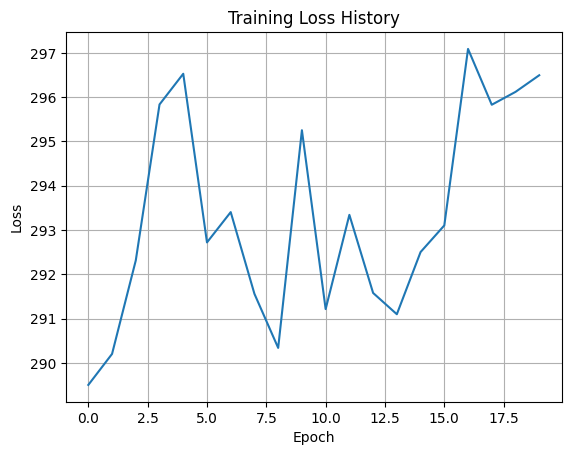

In [29]:
model = Small1DCNN(imu_input_dim=imu_segments[0].shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for imu_batch, emg_batch in dataloader:
        optimizer.zero_grad()
        pred = model(imu_batch)
        loss = criterion(pred, emg_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    loss_history.append(epoch_loss)

# Plot training loss
plt.plot(loss_history)
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()


In [30]:
# Assuming you have one segment's IMU data:
imu_segment_test = imu_segments[0]  # shape: (seq_len, imu_features)

# Convert to tensor
imu_tensor = torch.tensor(imu_segment_test, dtype=torch.float32)

# Add batch dimension
imu_tensor = imu_tensor.unsqueeze(0)  # shape: (1, seq_len, imu_features)

# Model in eval mode
model.eval()
with torch.no_grad():
    predicted_emg = model(imu_tensor)  # shape: (1, seq_len, 1)

# Remove batch dimension
predicted_emg = predicted_emg.squeeze(0).squeeze(-1).numpy()  # shape: (seq_len,)


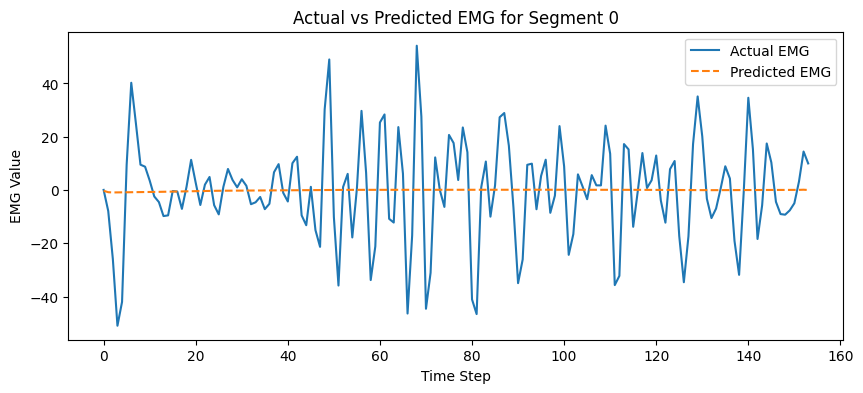

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(emg_segments[0], label='Actual EMG')
plt.plot(predicted_emg, label='Predicted EMG', linestyle='--')
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("EMG Value")
plt.title("Actual vs Predicted EMG for Segment 0")
plt.show()
